In [3]:
%load_ext autoreload
%autoreload 2

# Preparations

In [1]:
import mkl
mkl.set_num_threads(1)

48

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
%run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
%run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!
icecube (full) astro events: 3190.520945849161
Below -4.87 deg, A_eff is set to 0
starting aeff rotations
Saving up-going effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_upgoing.pckl
starting full effective area calculation...
Saving full effective areas to /home/hpc/capn/capn102h/repos/Plenum/resources/tabulated_logE_sindec_aeff_full.pckl
finished!
Flux will be saved to: /home/hpc/capn/capn102h/repos/Plenum/resources/MCEq_daemonflux.pckl
args: Namespace(renew_calc=False, kde=False)
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/e_psf_grid_psimax-3_bins-25_KDE.pckl
running gaussian-process resolution smoothing
file exists: /home/hpc/capn/capn102h/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
499 declination bins
140 log_10(energy) bins
499 declination bins
Saving background flux to:  /home/hpc/capn/capn102h/repos/Plenum/local/atmospheric_background_daemonflux_MH.pckl and /home/hpc/capn/c

# Imports

In [3]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b

from scipy.stats import chi2
from settings import LOCALPATH, BASEPATH, sigma5
import settings as st
from tools import array_source_interp,  get_scaler, scaling_estimation
from likelihood import setup_multi_llh, ps_llh_multi, ps_llh_single
from tqdm import tqdm

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [4]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}


In [5]:
# plot settings for different detector_configurations
IC_North_det = "KM3NeT"
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube (IC) 14 yr (est.)",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    IC_North_det: {
        "color": "#66cccc",
        "ls": "--",
        "label": f"IC 14 yr + {IC_North_det} 10 yr",
        "plainlabel": IC_North_det,
        "marker": "v",
    },
    # "KM3NeT": {
    #     "color": "#66cccc",
    #     "ls": "--",
    #     "label": "IC + KM3NeT",
    #     "plainlabel": "KM3NeT",
    #     "marker": "v",
    # },
    "KM3NeT-only": {
        "color": "#66cccc",
        "ls": "-.",
        "label": "KM3NeT 10 yr",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#a50000",
        "ls": "-",
        "label": r"IceCube + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "purple",
        "ls": "--",
        "label": r"IceCube + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
    
    "Plenum-3": {
        "color": "indigo",
        "ls": "-.",
        "label": r"IceCube + PLE$\nu$M-3",
        "plainlabel": r"PLE$\nu$M-3",
        "marker": "o",
    },
}

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [6]:
with open(join(LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

# Atmospheric background
Actually, we would need to account for the different zenith regions of a source, if the detector is not at one of the poles.
This is currently not yet implemented

In [7]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [8]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [9]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# Flux definition

In [10]:
from fluxes import PL_flux, flux_collection
from settings import PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME

## NGC1068 source parameters

In [11]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

In [12]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

## Check event numbers

In [13]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10**aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85

ngc 1068: 96.7963360437023


# Discovery potential vs dec


## baseline analysis

In [15]:
# standard
thresholds = [sigma5]
detector_keys = [
    "IceCube" ,
    "P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]
decs = np.arange(-90, 91, step=5)

tmp = []  # save output here
for ident in detector_keys:
    conf = st.detector_configurations[ident]
    
    for dec in tqdm(np.deg2rad(decs)):
        if "IceCube" in ident and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_flux
        )
        # calculate an estimate for the flux scaling
        scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the 5-sigma discovery threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                shape="powerlaw",
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_flux.E0,
                phi_0=ngc_flux.norm,
            )
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_multi(x, **dct)

            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_flux.gamma),
                approx_grad=True,
            )
            pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_b": np.sum(all_k_b),
                "n_sig": np.sum(current_k_s),
                "pval": pval,
                "log10(p)": -np.log10(pval),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:48<00:00,  1.30s/it]


KeyError: 'P-ONE'

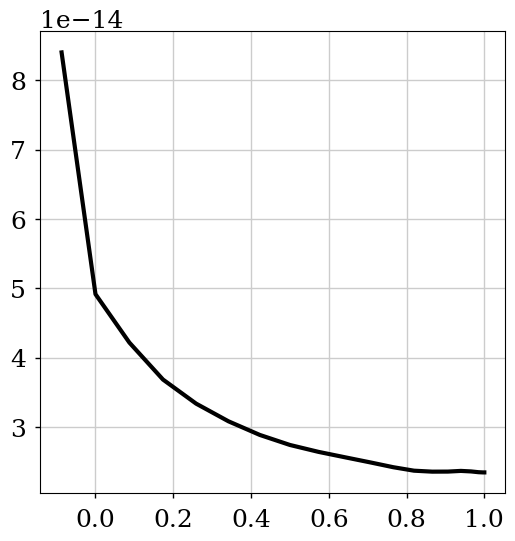

In [16]:
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5)) * PHI_NGC,
    columns=["disc5"],
).reset_index()
flux["dec_deg"] = np.rad2deg(flux.dec)

f, ax = plt.subplots(figsize=(6, 6))
for ident, series in flux.groupby("ident"):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )
ax.set_yscale("log")
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
ax.set_ylim(8e-15, 1e-13)
ax.set_xlim(-1, 1)
font_color = "0.35"
for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(ngc_flux.norm / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=0.97,
        y=ngc_flux.norm / ii,
        va="bottom",
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large",
        ha="right",
    )
ax.text(
    0.2, -0.175, "South", fontsize="x-large", color=font_color, transform=ax.transAxes
)
ax.text(
    0.8,
    -0.175,
    "North",
    ha="right",
    fontsize="x-large",
    color=font_color,
    transform=ax.transAxes,
)

f.subplots_adjust(top=0.72)
ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")

## single detectors

In [20]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
loc = EarthLocation(lat=st.poles["P-ONE"]["lat"], lon=st.poles["P-ONE"]["lon"])
# arbitrary time, doesnt matter here
time = Time("2021-6-21 00:00:00")
local_coords = SkyCoord(0 * u.deg, 5 * u.deg, frame = AltAz(obstime=time, location=loc))
threshold_dec_pone = local_coords.transform_to("icrs").dec

In [31]:
# + single detector money plot gamma= 2 and 3
thresholds = [sigma5]
detector_keys = [
    "IceCube",
    "P-ONE-only" 
]
decs = np.arange(-90, 91, step=5)
gammas = [2, 3]
fluxes = {}


tmp = []  # save output here
for gamma, ident in product(gammas, detector_keys):
    conf = st.detector_configurations[ident]
    fluxes[gamma] = PL_flux(1E-14 if gamma==3 else 1E-15, gamma, st.E0_NGC, "powerlaw")
    for dec in tqdm(np.deg2rad(decs)):
        if ("IceCube" in ident and dec < np.deg2rad(-5)) or ("P-ONE" in ident and dec > np.deg2rad(threshold_dec_pone.value)):
            # skip where aeff = 0
            continue
        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["baseline"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=fluxes[gamma]
        )
        # calculate an estimate for the flux scaling
        scaler = 4 if gamma==3 else 0.5
        scaler /= (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the 5-sigma discovery threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                shape="powerlaw",
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=fluxes[gamma].E0,
                phi_0=fluxes[gamma].norm,
            )
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_multi(x, **dct)

            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_flux.gamma),
                approx_grad=True,
            )
            tmp_pval = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2))

            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "gamma": gamma,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_b": np.sum(all_k_b),
                "n_sig": np.sum(current_k_s),
                "log10(p)": tmp_pval,
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.gamma == gamma)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "disc_pot_P-ONE.pickle"))

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:09<00:00,  3.93it/s]


(5e-15, 2e-13)

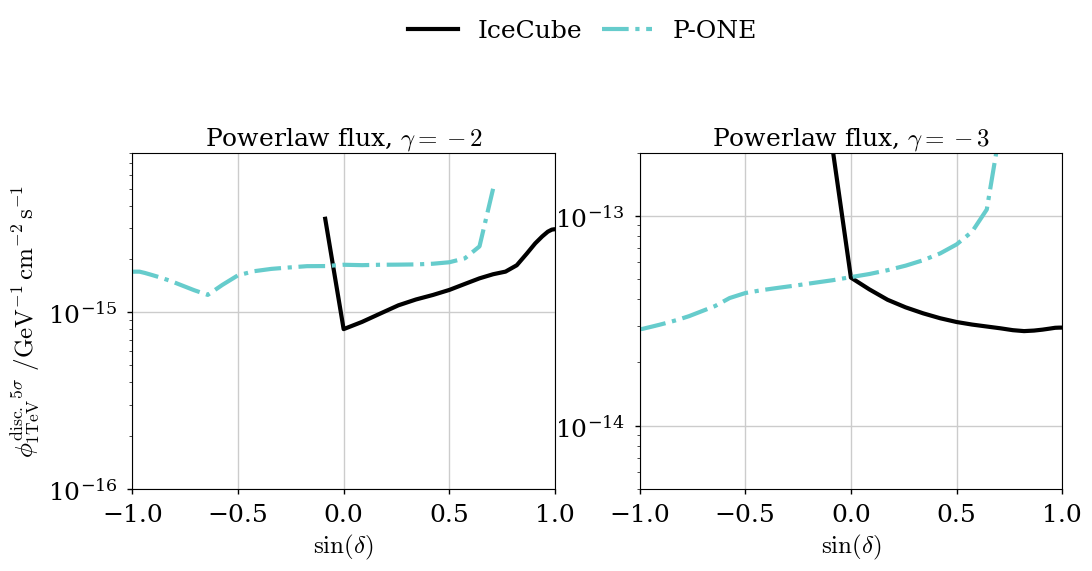

In [32]:
df = pd.read_pickle(join(LOCALPATH, "disc_pot_P-ONE.pickle"))
flux = pd.DataFrame(
    df.dropna().groupby(["ident", "dec", "gamma"], sort=False).apply(lambda x: get_scaler(x, sigma5)),
    columns=["disc5"],
).reset_index()

f, axes = plt.subplots(ncols=2, figsize=(12, 6))
for (ident, gamma), series in flux.groupby(["ident", "gamma"], sort=False):
    if gamma == 2:
        ax = axes[0]
        kwgs = {k: det_plotting[ident][k] for k in ["ls", "color", "label"]}
    else:
        ax = axes[1]
        kwgs = {k: det_plotting[ident][k] for k in ["ls", "color"]}
    ax.plot(
        np.sin(series.dec),
        series.disc5 * fluxes[gamma].norm,
        lw=3,
        **kwgs,
    )
# # get handles and labels
# handles, labels = axes[0].get_legend_handles_labels()
# # specify order of items in legend
# order = [1, 2, 0, 3, 4]
# # add legend to plot

f.legend(
    # [handles[idx] for idx in order],
    # [labels[idx] for idx in order],
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)

for ax in axes:
    ax.set_yscale("log")
    # ax.axhline(ngc_flux.norm, ls="--", lw=2, color="k", zorder=0)
    # ax.axhline(ngc_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    # ax.axhline(ngc_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)

    ax.set_xlabel(r"$\sin(\delta)$")

    ax.set_xlim(-1, 1)

axes[0].set_ylabel(
    r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
axes[0].set_title(rf"Powerlaw flux, $\gamma=-{2}$")
axes[1].set_title(rf"Powerlaw flux, $\gamma=-{3}$")


f.subplots_adjust(top=0.67)

axes[0].set_ylim(1e-16, 8e-15)
axes[1].set_ylim(5e-15, 2e-13)


## multi detector

In [17]:
# + single detector money plot gamma= 2 and 3
thresholds = [sigma5]
detector_keys = [
    "IceCube" ,
    "KM3NeT-only",
    "KM3NeT" ,
    "Plenum-1",
    "Plenum-2",
    "Plenum-3",
]
decs = np.arange(-90, 91, step=10)
gammas = [3.2]
fluxes = {}
for gamma, ident in product(gammas, detector_keys):
    fluxes[gamma] = ngc_flux #PL_flux(1E-14 if gamma==3 else 1E-15, gamma, st.E0_NGC, "powerlaw")


In [18]:

tmp = []  # save output here
for gamma, ident in product(gammas, detector_keys):
    conf = st.detector_configurations[ident]
    print(conf)
    fluxes[gamma] = ngc_flux #PL_flux(1E-14 if gamma==3 else 1E-15, gamma, st.E0_NGC, "powerlaw")
    for dec in tqdm(np.deg2rad(decs)):
        if "IceCube" in ident and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=fluxes[gamma]
        )
        # calculate an estimate for the flux scaling
        scaler = 4 #if gamma==3 else 0.5
        scaler /= (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the 5-sigma discovery threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                shape="powerlaw",
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=fluxes[gamma].E0,
                phi_0=fluxes[gamma].norm,
            )
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_multi(x, **dct)

            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_flux.gamma),
                approx_grad=True,
            )
            pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
            tmp_pval = -np.log10(pval)

            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "gamma": gamma,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_b": np.sum(all_k_b),
                "n_sig": np.sum(current_k_s),
                "log10(p)": tmp_pval,
                "pval": pval,
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.gamma == gamma)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "disc_pot_multi_ngc.pickle"))
# df.to_pickle(join(LOCALPATH, "disc_pot_multi_gamma23.pickle"))

(['IceCube'], [1.4])


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:03<00:00,  6.19it/s]


(['KM3NeT'], [1])


 95%|█████████▍| 18/19 [00:09<00:01,  1.51s/it]

Optimization failed! Diff is: -0.27084226605169803 thresh is: 1.433257859617676e-07


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


(['IceCube', 'KM3NeT'], [2.4, 1])


100%|██████████| 19/19 [00:10<00:00,  1.75it/s]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2.4, 1, 1, 1])


100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.9, 1, 1, 1])


100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT'], [8.9, 1, 1, 31, 2.333333333333333])


100%|██████████| 19/19 [00:35<00:00,  1.87s/it]


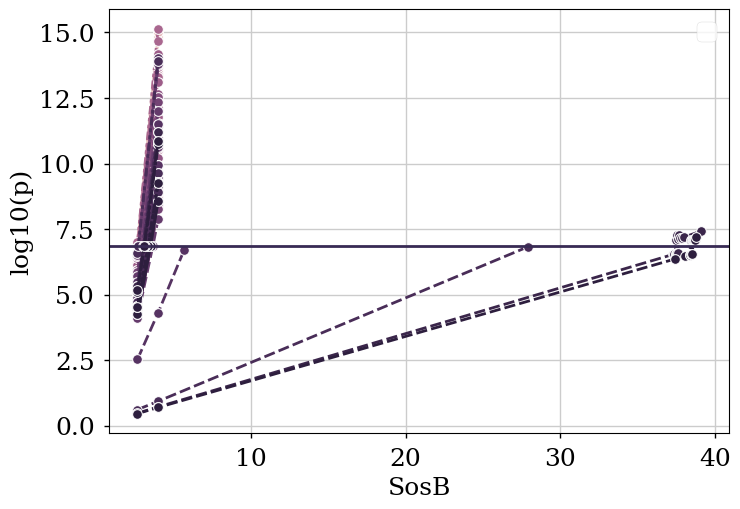

In [19]:
df = pd.DataFrame(tmp)
ax = sns.lineplot(data=df, y="log10(p)", x="SosB", hue="dec", marker="o", style="ident")
ax.legend([])
for t in thresholds:
    plt.axhline(-np.log10(t))
# plt.ylim(6, 7)
# plt.xlim(4.5, 6)

In [24]:
df = pd.read_pickle(join(LOCALPATH, "disc_pot_multi_ngc.pickle"))
# df = pd.read_pickle(join(LOCALPATH, "disc_pot_multi_gamma23.pickle"))
flux = pd.DataFrame(
    df.dropna().groupby(["ident", "dec", "gamma"], sort=False).apply(lambda x: get_scaler(x, sigma5)),
    columns=["disc5"],
).reset_index()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


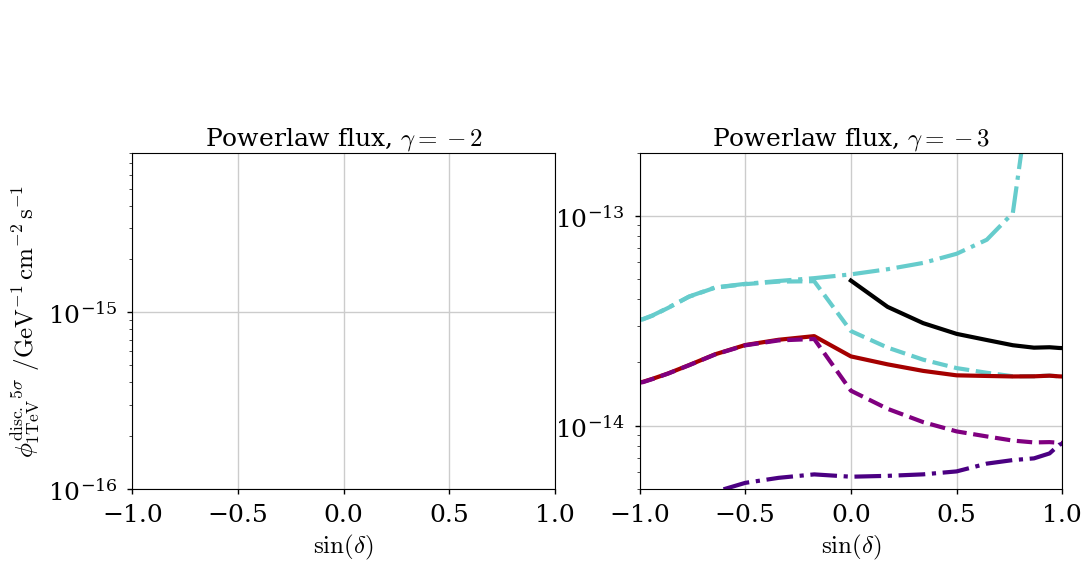

In [21]:

f, axes = plt.subplots(ncols=2, figsize=(12, 6))
for (ident, gamma), series in flux.groupby(["ident", "gamma"], sort=False):
    if gamma == 2:
        ax = axes[0]
        kwgs = {k: det_plotting[ident][k] for k in ["ls", "color", "label"]}
    else:
        ax = axes[1]
        kwgs = {k: det_plotting[ident][k] for k in ["ls", "color"]}
    ax.plot(
        np.sin(series.dec),
        series.disc5 * fluxes[gamma].norm,
        lw=3,
        **kwgs,
    )
# # get handles and labels
# handles, labels = axes[0].get_legend_handles_labels()
# # specify order of items in legend
# order = [1, 2, 0, 3, 4]
# # add legend to plot

f.legend(
    # [handles[idx] for idx in order],
    # [labels[idx] for idx in order],
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)

for ax in axes:
    ax.set_yscale("log")
    # ax.axhline(ngc_flux.norm, ls="--", lw=2, color="k", zorder=0)
    # ax.axhline(ngc_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    # ax.axhline(ngc_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)

    ax.set_xlabel(r"$\sin(\delta)$")

    ax.set_xlim(-1, 1)

axes[0].set_ylabel(
    r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
axes[0].set_title(rf"Powerlaw flux, $\gamma=-{2}$")
axes[1].set_title(rf"Powerlaw flux, $\gamma=-{3}$")


f.subplots_adjust(top=0.67)

axes[0].set_ylim(1e-16, 8e-15)
axes[1].set_ylim(5e-15, 2e-13)


f.savefig(
    join(BASEPATH, "plots/ngc_paper/ngc_disc_pot_km3net_gamma23.pdf"),
    bbox_inches="tight",
)

# iterative plotting

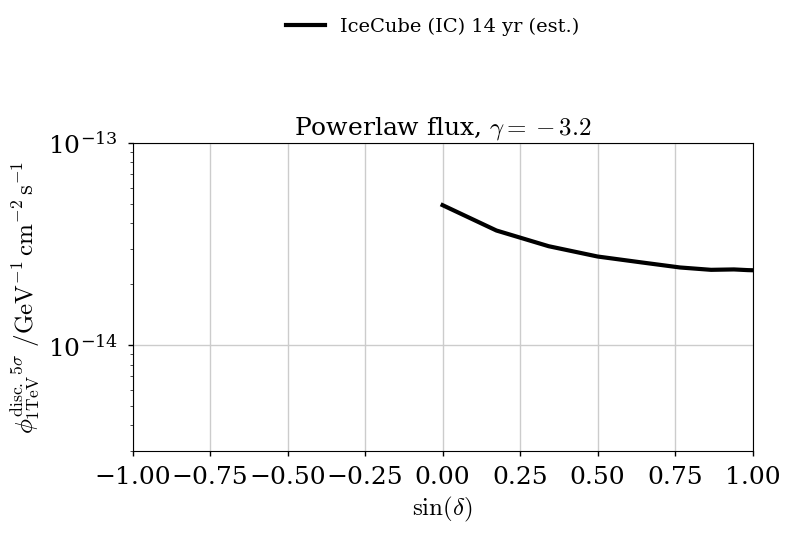

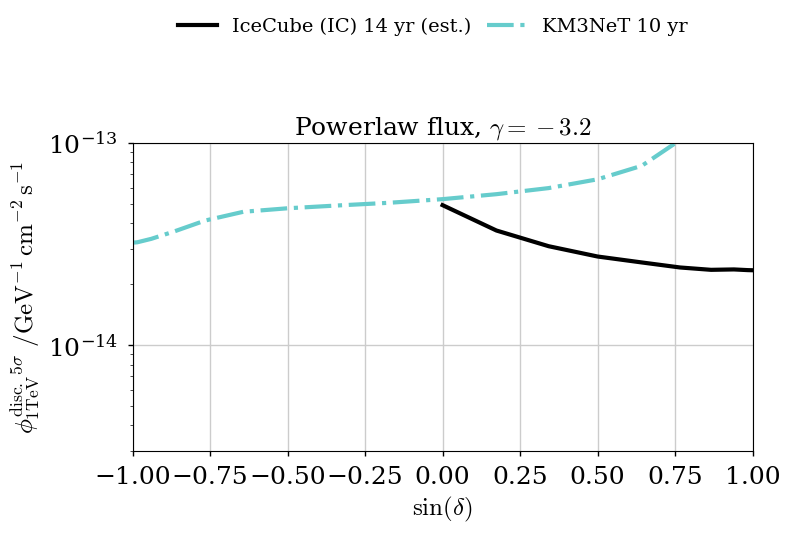

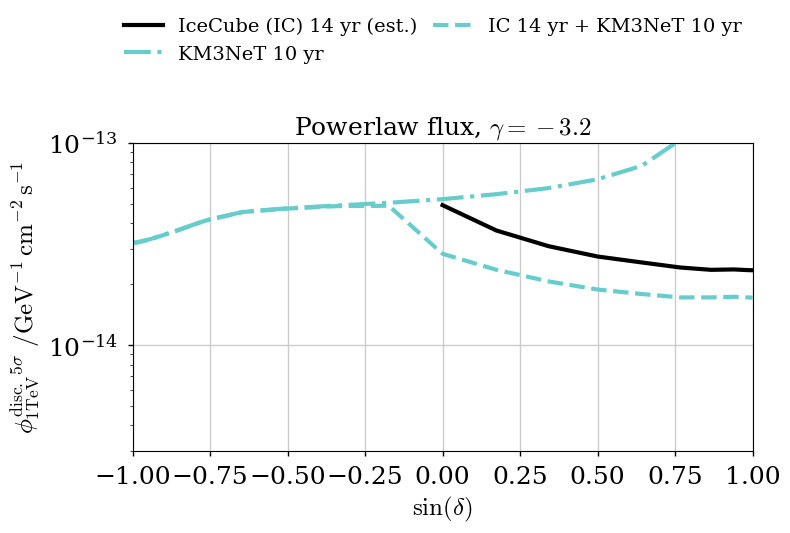

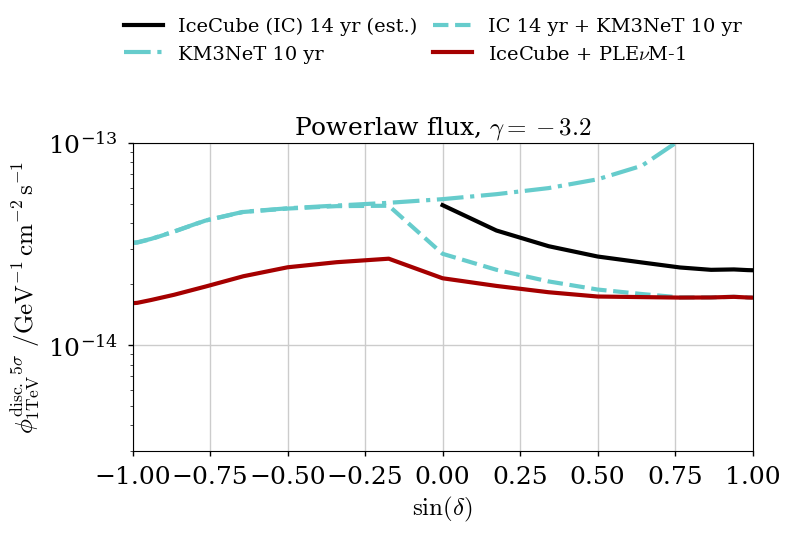

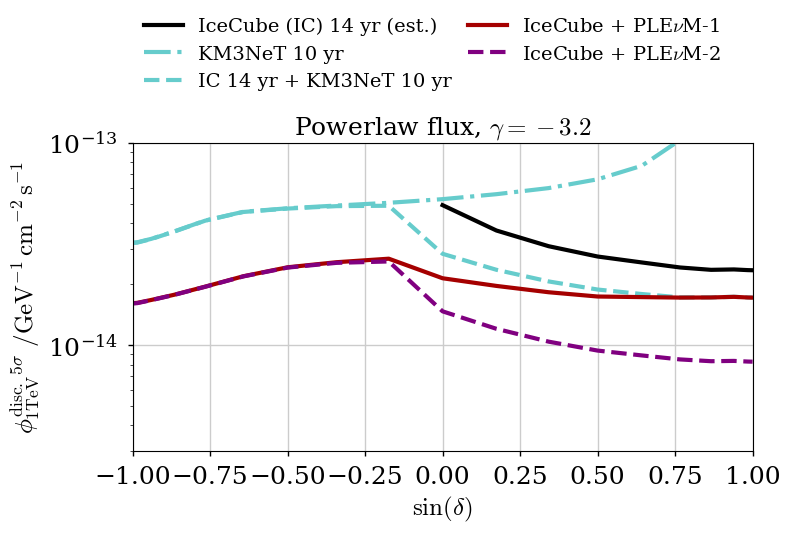

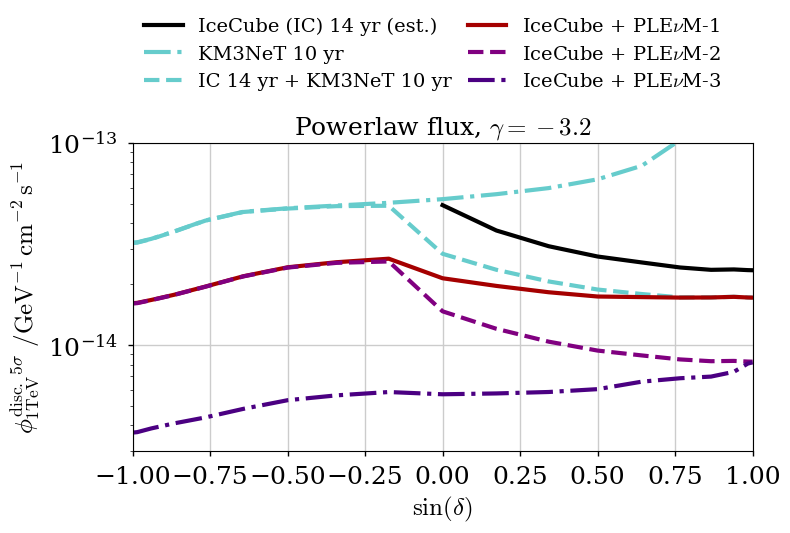

In [26]:
detector_keys = [
    "IceCube" ,
    "KM3NeT-only" ,
    "KM3NeT" ,
    # "IC+P1+K3",
    "Plenum-1",
    # "IceCube+Gen2",
    "Plenum-2",
    "Plenum-3",
]
for ii in range(1, len(detector_keys)+1):

    mask = flux.ident == "IceCube"
    if ii!=1:
        for jj in detector_keys[1:ii]:
            mask |= (flux.ident==jj)
    selection = flux.loc[mask]

    f, ax = plt.subplots()
    for ident, series in selection.groupby("ident", sort=False):
        kwgs = {k: det_plotting[ident][k] for k in ["ls", "color", "label"]}
        ax.plot(
            np.sin(series.dec),
            series.disc5 * ngc_flux.norm,
            lw=3,
            **kwgs,
        )
    # # get handles and labels
    # handles, labels = axes[0].get_legend_handles_labels()
    # # specify order of items in legend
    # order = [1, 2, 0, 3, 4]
    # # add legend to plot

    f.legend(
        # [handles[idx] for idx in order],
        # [labels[idx] for idx in order],
        loc="upper center",
        frameon=False,
        fontsize=14,
        ncol=2,
        bbox_to_anchor=(0.5, 0.93),
        columnspacing=0.8,
    )

    ax.set_yscale("log")
    # ax.axhline(ngc_flux.norm, ls="--", lw=2, color="k", zorder=0)
    # ax.axhline(ngc_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    # ax.axhline(ngc_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)

    ax.set_xlabel(r"$\sin(\delta)$")

    ax.set_xlim(-1, 1)

    ax.set_ylabel(
        r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
    )
    ax.set_title(rf"Powerlaw flux, $\gamma=-{3.2}$")


    f.subplots_adjust(top=0.67)

    ax.set_ylim(3e-15, 1e-13)


# f.savefig(
#     join(BASEPATH, "plots/ngc_paper/ngc_disc_pot_km3net_gamma23.pdf"),
#     bbox_inches="tight",
# )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


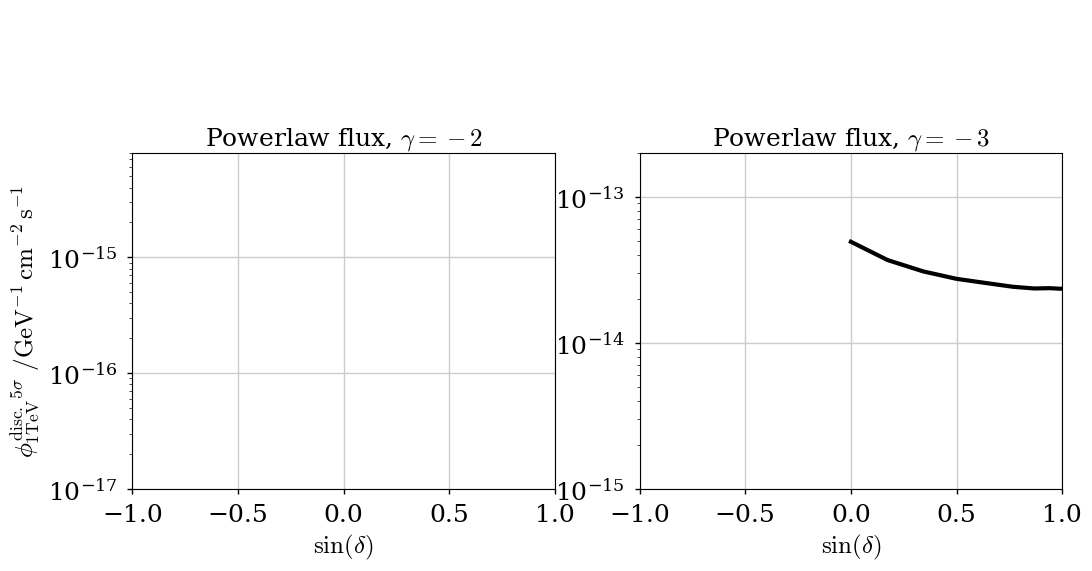

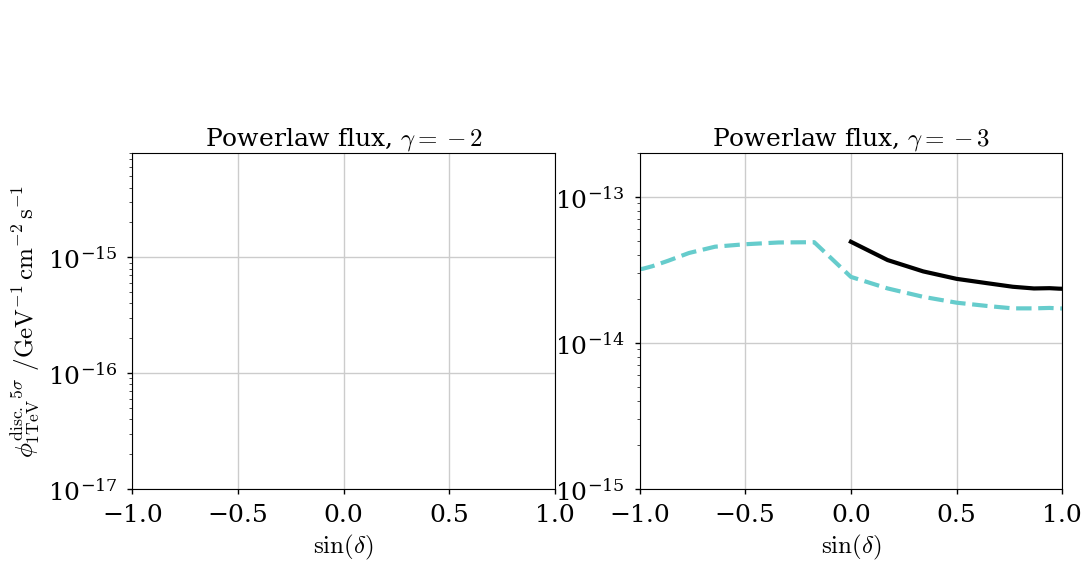

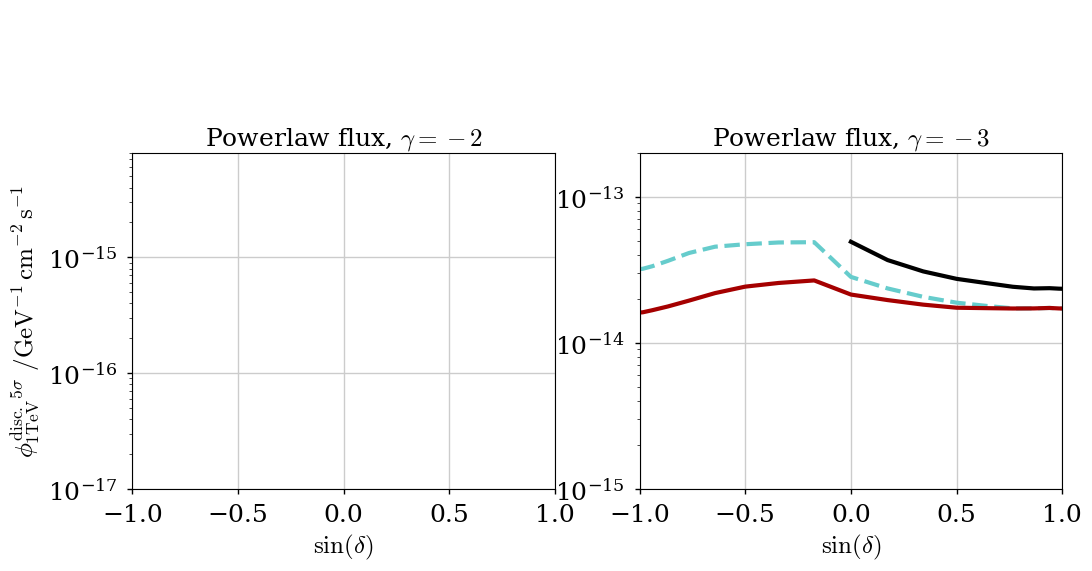

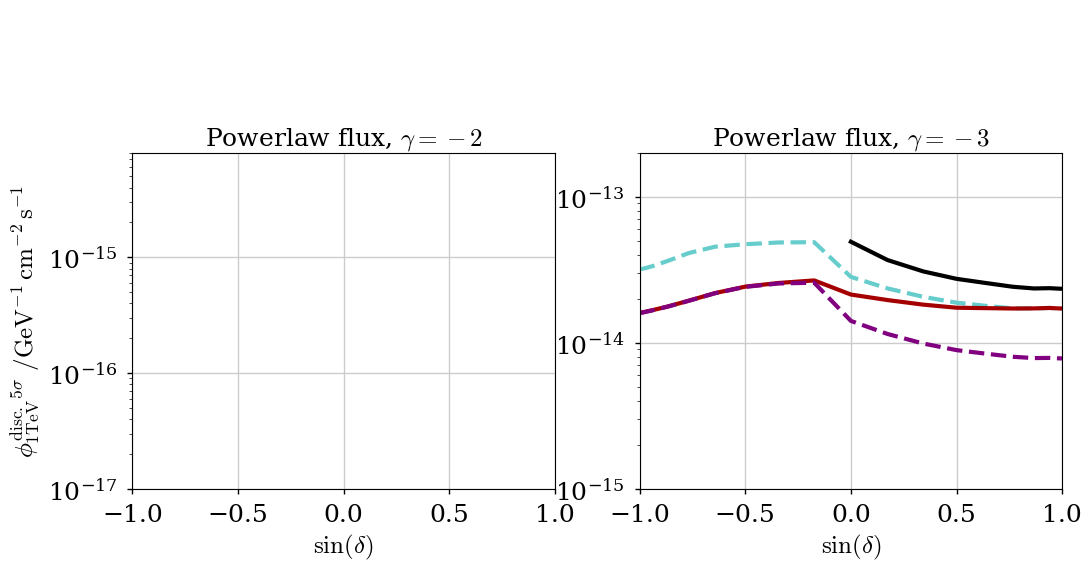

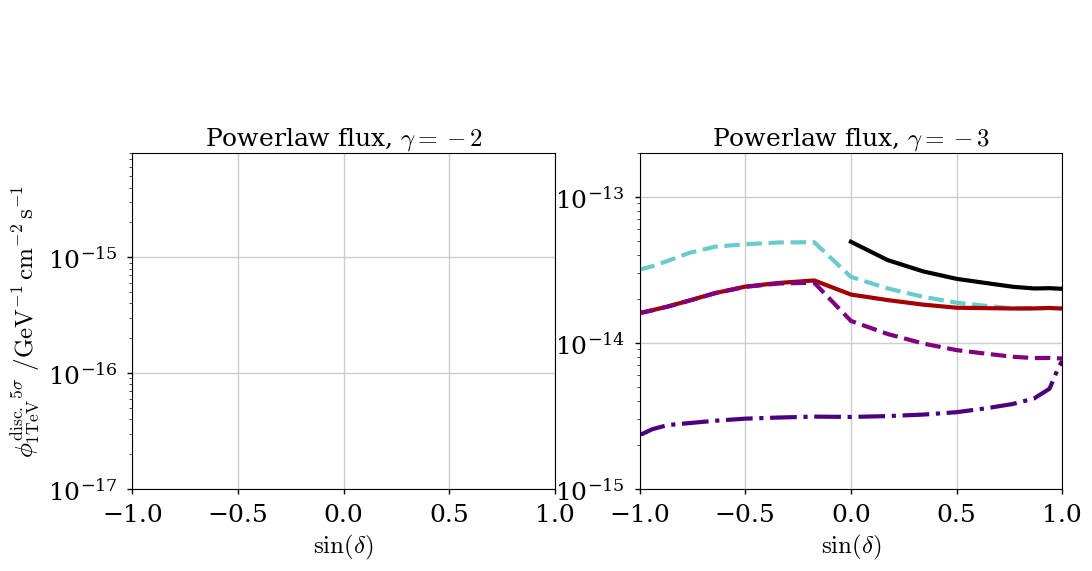

In [46]:
detector_keys = [
    "IceCube" ,
    "KM3NeT" ,
    # "IC+P1+K3",
    "Plenum-1",
    # "IceCube+Gen2",
    "Plenum-2",
    "Plenum-3",
]
for ii in range(1, len(detector_keys)+1):

    mask = flux.ident == "IceCube"
    if ii!=1:
        for jj in detector_keys[1:ii]:
            mask |= (flux.ident==jj)
    selection = flux.loc[mask]

    f, axes = plt.subplots(ncols=2, figsize=(12, 6))
    for (ident, gamma), series in selection.groupby(["ident", "gamma"], sort=False):
        if gamma == 2:
            ax = axes[0]
            kwgs = {k: det_plotting[ident][k] for k in ["ls", "color", "label"]}
        else:
            ax = axes[1]
            kwgs = {k: det_plotting[ident][k] for k in ["ls", "color"]}
        ax.plot(
            np.sin(series.dec),
            series.disc5 * fluxes[gamma].norm,
            lw=3,
            **kwgs,
        )
    # # get handles and labels
    # handles, labels = axes[0].get_legend_handles_labels()
    # # specify order of items in legend
    # order = [1, 2, 0, 3, 4]
    # # add legend to plot

    f.legend(
        # [handles[idx] for idx in order],
        # [labels[idx] for idx in order],
        loc="upper center",
        frameon=False,
        # fontsize=14,
        ncol=2,
        bbox_to_anchor=(0.5, 0.93),
        columnspacing=0.8,
    )

    for ax in axes:
        ax.set_yscale("log")
        # ax.axhline(ngc_flux.norm, ls="--", lw=2, color="k", zorder=0)
        # ax.axhline(ngc_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
        # ax.axhline(ngc_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)

        ax.set_xlabel(r"$\sin(\delta)$")

        ax.set_xlim(-1, 1)

    axes[0].set_ylabel(
        r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
    )
    axes[0].set_title(rf"Powerlaw flux, $\gamma=-{2}$")
    axes[1].set_title(rf"Powerlaw flux, $\gamma=-{3}$")


    f.subplots_adjust(top=0.67)

    axes[0].set_ylim(1e-17, 8e-15)
    axes[1].set_ylim(1e-15, 2e-13)


# f.savefig(
#     join(BASEPATH, "plots/ngc_paper/ngc_disc_pot_km3net_gamma23.pdf"),
#     bbox_inches="tight",
# )